In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load the merged data
df = pd.read_csv("merged.csv")

# Convert 'NoEvent', 'Unknown', 'Not Applicable' to 0
df.replace(["NoEvent", "Unknown", "Not Applicable"], 0, inplace=True)

#Standardize column names
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
print("\n🧾 Here are all your cleaned column names:\n")
print(df.columns.tolist())


🧾 Here are all your cleaned column names:

['ee_#', 'job_title', 'current_employment_status', 'project', 'project_code', 'original_hire_date', 'last_hire_date', 'los_in_days', 'termination_date', 'reason_code', 'left', 'fired', 'promotion_date', 'demotion_date', 'rehire_date', 'transfer_in_date', 'transfer_out_date', 'days_since_promotion', 'days_since_demotion', 'days_since_rehire', 'days_since_transfer_in', 'days_since_transfer_out', 'days_since_termination', 'flsa_exempt']


In [3]:
# Install XGBoost
!pip install xgboost --quiet

# Encode categorical features
categorical_cols = ['job_title', 'project_code', 'flsa_exempt']
for col in categorical_cols:
    if col in df.columns:
        df[col] = LabelEncoder().fit_transform(df[col].astype(str))
    else:
        print(f"⚠️ Column '{col}' not found in dataset — skipping.")

# Create churn column based on 'left' and 'fired'
df['churn'] = ((df['left'] == 1) | (df['fired'] == 1)).astype(int)

# Check class distribution
print(df['churn'].value_counts())

# Redefine features and target (in case you've run other blocks)
features = ['days_since_promotion', 'days_since_demotion', 'days_since_transfer_in',
            'days_since_transfer_out', 'days_since_rehire', 'job_title',
            'project_code', 'flsa_exempt', 'los_in_days']
X = df[features].apply(pd.to_numeric, errors='coerce').fillna(0)
y = df['churn']

# Train-test split with stratify to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# XGBoost Classifier
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred_xgb))


churn
0    7242
1    5122
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:47:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Confusion Matrix:
 [[1874  299]
 [ 366 1171]]

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.86      0.85      2173
           1       0.80      0.76      0.78      1537

    accuracy                           0.82      3710
   macro avg       0.82      0.81      0.81      3710
weighted avg       0.82      0.82      0.82      3710


Accuracy Score: 0.8207547169811321


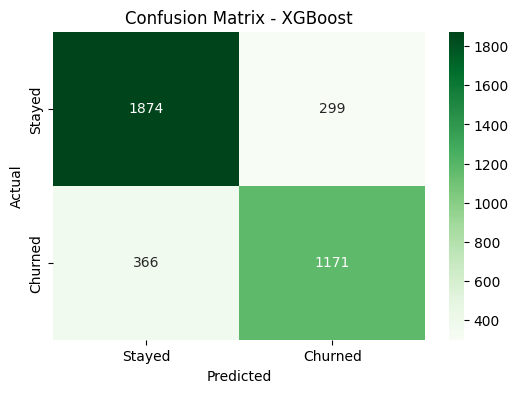

<Figure size 1000x600 with 0 Axes>

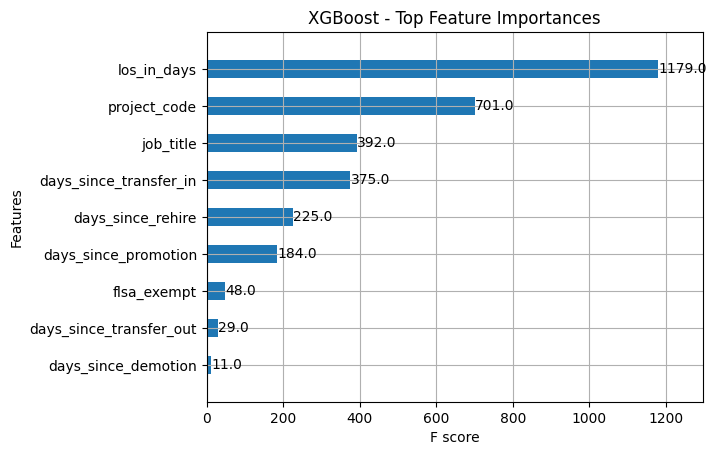

In [4]:
# Confusion matrix heatmap
conf_matrix = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=['Stayed', 'Churned'], yticklabels=['Stayed', 'Churned'])
plt.title('Confusion Matrix - XGBoost')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Feature importance
plt.figure(figsize=(10,6))
xgb.plot_importance(xgb_model, max_num_features=10, height=0.5)
plt.title('XGBoost - Top Feature Importances')
plt.show()


In [ ]:
# Define and train model (if not already done)
import xgboost as xgb

model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42
)
model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

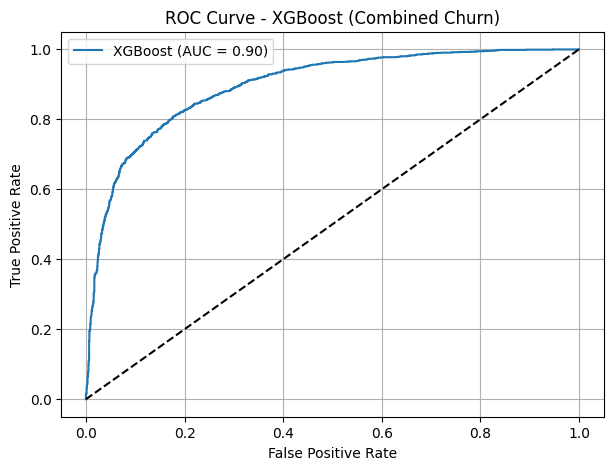

In [ ]:
from sklearn.metrics import roc_curve, auc

y_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # diagonal
plt.title('ROC Curve - XGBoost (Combined Churn)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()


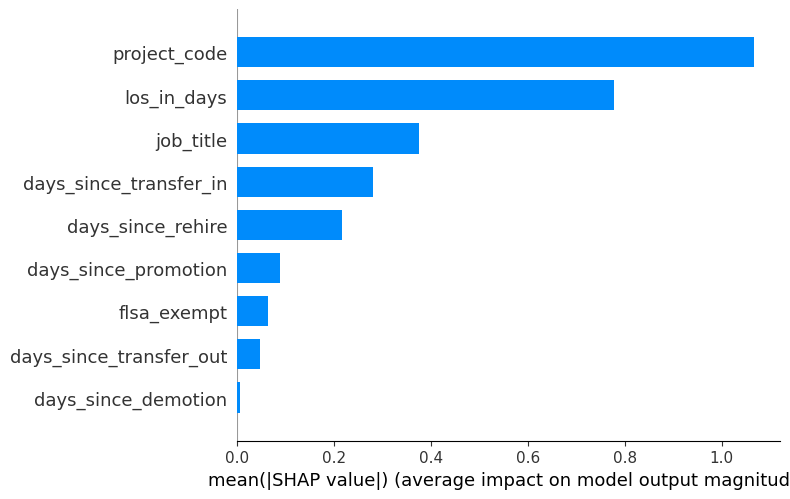

In [ ]:
!pip install shap

import shap
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")


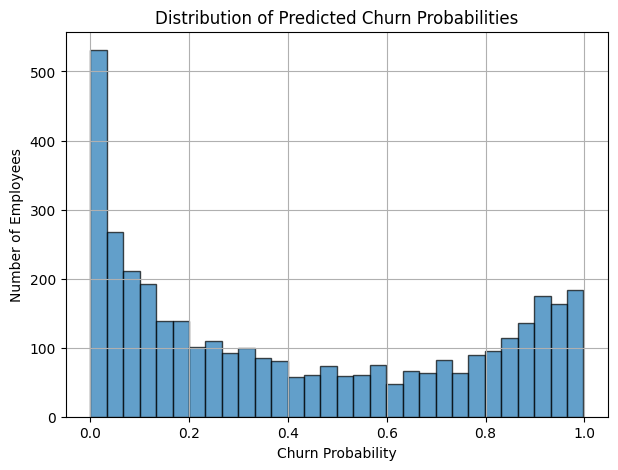

In [ ]:
plt.figure(figsize=(7,5))
plt.hist(y_proba, bins=30, edgecolor='k', alpha=0.7)
plt.title("Distribution of Predicted Churn Probabilities")
plt.xlabel("Churn Probability")
plt.ylabel("Number of Employees")
plt.grid(True)
plt.show()


In [ ]:
df['churn_probability'] = model.predict_proba(X)[:, 1]

# Optional: Include Employee ID (like ee_#) if available
if 'ee_#' in df.columns:
    top_risk = df[['ee_#', 'churn_probability'] + features].sort_values(by='churn_probability', ascending=False).head(20)
else:
    top_risk = df[['churn_probability'] + features].sort_values(by='churn_probability', ascending=False).head(20)

import pandas as pd
import IPython.display as display
display.display(top_risk)


,ee_#,churn_probability,days_since_promotion,days_since_demotion,days_since_transfer_in,days_since_transfer_out,days_since_rehire,job_title,project_code,flsa_exempt,los_in_days
7158,308957,0.998694,NaN,NaN,645.0,NaN,NaN,74,86,0,81
377,229788,0.998371,NaN,NaN,1128.0,NaN,NaN,131,109,1,21
5005,303209,0.998182,NaN,NaN,719.0,NaN,NaN,77,85,0,114
246,240334,0.998101,NaN,NaN,NaN,NaN,NaN,151,16,0,873
188,234387,0.998101,NaN,NaN,NaN,NaN,NaN,151,21,0,874
24,203618,0.998088,NaN,NaN,NaN,NaN,NaN,151,26,0,892
247,240340,0.998024,NaN,NaN,NaN,NaN,NaN,151,13,0,683
139,234367,0.998024,NaN,NaN,NaN,NaN,NaN,151,11,0,769
185,234346,0.997883,NaN,NaN,NaN,NaN,NaN,151,16,0,1131
109,234542,0.997819,NaN,NaN,NaN,NaN,NaN,151,14,0,565
